In [19]:
from array import array
import os
from PIL import Image
import sys
import time
import re
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
from geopy.distance import geodesic
import folium
import holidays

# Load OCR-Processed travel history


In [4]:
df = pd.read_csv(r"C:\Users\gerga\Downloads\rejsekort_jpg_extracted.csv")
df = df.sort_values(by=["Date", "Departure Time"])


In [ ]:
#Very basic preliminary stats
total_trips = len(df)
total_spent = df["Fare DKK"].sum()
average_fare = df["Fare DKK"].mean()

# Create a route column
df["Route"] = df["Departure Stop"] + " → " + df["Arrival Stop"]

# Find most common route
most_common_route = df["Route"].mode()[0]
most_common_route_count = df["Route"].value_counts().iloc[0]

summary = {
    "Total Trips": total_trips,
    "Total Spent (DKK)": round(total_spent, 2),
    "Average Fare (DKK)": round(average_fare, 2),
    "Most Common Route": most_common_route,
    "Most Common Route Count": most_common_route_count
}

summary_df = pd.DataFrame([summary])

In [4]:
print(summary_df)

   Total Trips  Total Spent (DKK)  Average Fare (DKK)   
0          255            4105.98                16.1  \

                                   Most Common Route  Most Common Route Count  
0  Silkeborgvej/Vestre Ringgade (Aarhus Kom) → Aa...                       17  


# Load GTFS stops data


In [5]:
gtfs = pd.read_csv(r"C:\Users\gerga\Downloads\stops.csv")
gtfs.columns = gtfs.columns.str.strip()

In [ ]:
# city centers coordinates for Aarhus and CPH
aarhus_center = (56.1629, 10.2039)
copenhagen_center = (55.6761, 12.5683)

radius_km = 25

def is_within_radius(lat, lon, center, radius_km):
    return geodesic((lat, lon), center).km <= radius_km

#Filtering the dataset with all stops in DK
gtfs["in_midt"] = gtfs.apply(lambda row: is_within_radius(row["stop_lat"], row["stop_lon"], aarhus_center, radius_km), axis=1)
gtfs["in_cph"] = gtfs.apply(lambda row: is_within_radius(row["stop_lat"], row["stop_lon"], copenhagen_center, radius_km), axis=1)

filtered_gtfs = gtfs[gtfs["in_midt"] | gtfs["in_cph"]]


In [7]:
filtered_gtfs=pd.DataFrame(filtered_gtfs)
filtered_gtfs.to_csv("filtered_stops.csv", index=False)

# To avoid having ot filter again, the filtered file will just be loaded in from now on

In [7]:
df = pd.read_csv(r"C:\Users\gerga\Downloads\rejsekort_jpg_extracted.csv")
df = df.sort_values(by=["Date", "Departure Time"])


filtered_gtfs = pd.read_csv(r"C:\Users\gerga\Downloads\filtered_stops.csv")

In [8]:
# Normalize function
def normalize(text):
    if pd.isna(text):
        return ""
    for phrase in ["(Letbane)"]:     #Removing Letbane from the stop names, as this is not mentioned in the GTFS data
        text = text.replace(phrase, "")
    text = text.replace("/", " ")
    return ''.join(c for c in text.lower() if c.isalnum() or c.isspace()).strip()


# Normalize GTFS stop names
filtered_gtfs["stop_name_clean"] = filtered_gtfs["stop_name"].apply(normalize)
stop_lookup = (
    filtered_gtfs
    .drop_duplicates(subset="stop_name_clean")
    .set_index("stop_name_clean")[["stop_lat", "stop_lon"]]
    .to_dict("index")
)

manual_aliases = {
    "københavns lufthavn st metro": "cph lufthavn st togbus",  #Troubleshoot    
    "aarhus universitet ndr ringgade": "aarhus universitet nordre ringgade", #Working
    "aarhus banegårdsplads": "aarhus banegårdsplads banegårdspladsen",  #Working
    "vesterbro torv aarhus kom": "vesterbro torv langelandsgade aarhus kom", #Working
    "aarhus ø nikoline kochs plads aarhus kom": "nikoline kochs plads aarhus kom", #Working  
    "nørrebrogade nørre boulevard aarhus kom": "auh nørrebrogade nørre boulevard aarhus kom", #Working
}

for alias, correct in manual_aliases.items():
    if correct in stop_lookup:
        stop_lookup[alias] = stop_lookup[correct]


# Apply normalization to travel data
df["dep_clean"] = df["Departure Stop"].apply(normalize)
df["arr_clean"] = df["Arrival Stop"].apply(normalize)

# Map to coordinates
df["Dep_Lat"] = df["dep_clean"].map(lambda x: stop_lookup.get(x, {}).get("stop_lat"))
df["Dep_Lon"] = df["dep_clean"].map(lambda x: stop_lookup.get(x, {}).get("stop_lon"))
df["Arr_Lat"] = df["arr_clean"].map(lambda x: stop_lookup.get(x, {}).get("stop_lat"))
df["Arr_Lon"] = df["arr_clean"].map(lambda x: stop_lookup.get(x, {}).get("stop_lon"))

# Droping trips without matched coordinates
trips_clean = df.dropna(subset=["Dep_Lat", "Dep_Lon", "Arr_Lat", "Arr_Lon"])

# Create the map
m = folium.Map(location=[55.8, 11.3], zoom_start=7)
for _, row in trips_clean.iterrows():
    folium.PolyLine(
        locations=[(row["Dep_Lat"], row["Dep_Lon"]), (row["Arr_Lat"], row["Arr_Lon"])],
        color="blue",
        weight=2,
        opacity=0.6,
        tooltip=f"{row['Departure Stop']} → {row['Arrival Stop']} ({row['Fare DKK']} DKK)"
    ).add_to(m)

# Save map
map_path = r"C:\Users\gerga\OneDrive\Desktop\Rejsekort\rejsekort_journey_map.html"
m.save(map_path)
map_path


'C:\\Users\\gerga\\OneDrive\\Desktop\\Rejsekort\\rejsekort_journey_map.html'

In [9]:
print("Total trips:", len(df))
print("Trips with coordinates:", len(trips_clean))


Total trips: 255
Trips with coordinates: 254


In [10]:
unmatched = df[df[["Dep_Lat", "Arr_Lat"]].isnull().any(axis=1)]
unmatched=pd.DataFrame(unmatched)
print(unmatched)

           Date Departure Time             Departure Stop Arrival Time   
107  2024-11-09          09:26  Emdrup Søpark (Emdrupvej)        09:57  \

                    Arrival Stop  Fare DKK         Filename   
107  Margretheholm (Refshalevej)      17.8  Rejsekort 4.jpg  \

                   dep_clean                  arr_clean    Dep_Lat    Dep_Lon   
107  emdrup søpark emdrupvej  margretheholm refshalevej  55.721487  12.546397  \

     Arr_Lat  Arr_Lon  
107      NaN      NaN  


In [11]:
unmatched["arr_clean"].unique()


array(['margretheholm refshalevej'], dtype=object)

In [12]:
# Ensure the Date column is in datetime format
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Create a new Month column
df["Month"] = df["Date"].dt.to_period("M").astype(str)

# Group by Month to calculate total fare, number of trips, and average fare
monthly_summary = (
    df.groupby("Month")
      .agg(TotalFare_DKK=("Fare DKK", "sum"),
           NumTrips=("Fare DKK", "count"),
           AvgFare_DKK=("Fare DKK", "mean"))
      .reset_index()
)

print(monthly_summary)

     Month  TotalFare_DKK  NumTrips  AvgFare_DKK
0  2024-11         728.90        38    19.181579
1  2024-12         330.98        20    16.549000
2  2025-01         454.23        26    17.470385
3  2025-02         459.50        27    17.018519
4  2025-03         843.25        51    16.534314
5  2025-04         677.00        48    14.104167
6  2025-05         612.12        45    13.602667


# Adding features to the data - regionality; peak hour vs off-peak considerations

In [13]:
filtered_gtfs["Region"] = filtered_gtfs.apply(
    lambda row: "Midtjylland" if row["in_midt"] else ("Sjælland" if row["in_cph"] else "Other"),
    axis=1
)


# Ensure stop names are normalized
df["dep_clean"] = df["Departure Stop"].apply(normalize)
filtered_gtfs["stop_name_clean"] = filtered_gtfs["stop_name"].apply(normalize)

region_lookup = (
    filtered_gtfs[["stop_name_clean", "Region"]]
    .drop_duplicates(subset="stop_name_clean")
)

# Merge region info from GTFS onto df
df = df.merge(
    region_lookup,
    how="left",
    left_on="dep_clean",
    right_on="stop_name_clean"
)

# manually assign Region for missing stop_name
def manual_region_fallback(row):
    if pd.notnull(row["Region"]):
        return row["Region"]
    dep = str(row["Departure Stop"]).lower()
    arr = str(row["Arrival Stop"]).lower()
    if "aarhus" in dep or "aarhus" in arr:
        return "Midtjylland"
    else:
        return "Sjælland"

# Apply manual assignment
df["Region"] = df.apply(manual_region_fallback, axis=1)

# Count how many were updated this way for reference
num_missing_after = df["Region"].isnull().sum()

df["Region"].value_counts(dropna=False), num_missing_after


(Region
 Midtjylland    186
 Sjælland        69
 Name: count, dtype: int64,
 0)

In [14]:
# Load Danish public holidays
dk_holidays = holidays.Denmark()

# Ensure date column is datetime
df["Date"] = pd.to_datetime(df["Date"])
df["Hour"] = pd.to_datetime(df["Departure Time"], format="%H:%M", errors="coerce").dt.hour

# Get weekday (0 = Monday, 6 = Sunday)
df["Weekday"] = df["Date"].dt.weekday

# Function to classify off-peak eligibility
def is_off_peak(row):
    date = row["Date"]
    hour = row["Hour"]
    weekday = row["Weekday"]

    if pd.isna(hour):
        return False

    # Off-peak: weekends or public holidays
    if weekday >= 5 or date in dk_holidays:
        return True

    # Off-peak: weekday slots
    if (hour >= 18 or hour < 7) or (11 <= hour < 13):
        return True

    return False

# Apply tagging
df["OffPeak_Eligible"] = df.apply(is_off_peak, axis=1)

# Preview summary
print(df["OffPeak_Eligible"].value_counts())

OffPeak_Eligible
False    130
True     125
Name: count, dtype: int64


In [15]:
df["Month"] = df["Date"].dt.to_period("M").astype(str)

features = (
    df.groupby("Month")
      .agg(
          TotalFare_DKK=("Fare DKK", "sum"),
          NumTrips=("Fare DKK", "count"),
          OffPeakTrips=("OffPeak_Eligible", "sum"),  # Counts True values
          MidtjyllandTrips=("Region", lambda x: (x == "Midtjylland").sum()),
          SjaellandTrips=("Region", lambda x: (x == "Sjælland").sum())
      )
      .reset_index()
)

In [16]:
# Only consider Midtjylland trips
midt_df = df[df["Region"] == "Midtjylland"].copy()
midt_df["DepartureDT"] = pd.to_datetime(midt_df["Date"].astype(str) + " " + midt_df["Departure Time"], errors="coerce")
midt_df["ArrivalDT"] = pd.to_datetime(midt_df["Date"].astype(str) + " " + midt_df["Arrival Time"], errors="coerce")

# Sort by DepartureDT
midt_df = midt_df.sort_values("DepartureDT").reset_index()

# Initialize
midt_df["Midt_2hr_Eligible"] = False
group_id = 0
temp_group = []
window_start = None
window_end = None

for idx, row in midt_df.iterrows():
    if window_start is None:
        # Start the first window
        window_start = row["DepartureDT"]
        window_end = window_start + timedelta(minutes=135)
        temp_group = [row.name]
        continue

    # Check if current trip can fit into the current window based on ArrivalDT
    if row["ArrivalDT"] <= window_end:
        temp_group.append(row.name)
    else:
        # Evaluate the previous group
        group_df = midt_df.loc[temp_group]
        total_fare = group_df["Fare DKK"].sum()
        if len(group_df) > 1 and total_fare > 26:
            midt_df.loc[temp_group, "Midt_2hr_Eligible"] = True

        # Start a new window from the current trip
        window_start = row["DepartureDT"]
        window_end = window_start + timedelta(minutes=135)
        temp_group = [row.name]

# Handle the last group
if temp_group:
    group_df = midt_df.loc[temp_group]
    total_fare = group_df["Fare DKK"].sum()
    if len(group_df) > 1 and total_fare > 26:
        midt_df.loc[temp_group, "Midt_2hr_Eligible"] = True

# Merge eligibility back to the main df
df["Midt_2hr_Eligible"] = df.index.map(midt_df.set_index("index")["Midt_2hr_Eligible"].fillna(False))


In [17]:
df[df["Midt_2hr_Eligible"] == True]

,Date,Departure Time,Departure Stop,Arrival Time,Arrival Stop,Fare DKK,Filename,dep_clean,arr_clean,Dep_Lat,Dep_Lon,Arr_Lat,Arr_Lon,Month,stop_name_clean,Region,Hour,Weekday,OffPeak_Eligible,Midt_2hr_Eligible
62,2025-01-14,08:24,Park Allé/Banegårdspladsen (Aarhus Kom),08:34,Harald Jensens Plads/Skanderborgvej (Aarhus Kom),16.88,Rejsekort 20.jpg,park allé banegårdspladsen aarhus kom,harald jensens plads skanderborgvej aarhus kom,56.150764,10.202999,56.143574,10.188289,2025-01,park allé banegårdspladsen aarhus kom,Midtjylland,8,1,False,True
63,2025-01-14,09:27,Læssøesgade/Søndre Ringgade (Aarhus Kom),09:33,Silkeborgvej/Vestre Ringgade (Aarhus Kom),16.88,Rejsekort 20.jpg,læssøesgade søndre ringgade aarhus kom,silkeborgvej vestre ringgade aarhus kom,56.145814,10.187006,56.155392,10.182439,2025-01,læssøesgade søndre ringgade aarhus kom,Midtjylland,9,1,False,True
129,2025-03-13,12:01,Aarhus Universitetshospital Skejby indgang H,12:39,H. H. Seedorffs Stræde (Aarhus Kom),13.80,Rejsekort 41.jpg,aarhus universitetshospital skejby indgang h,h h seedorffs stræde aarhus kom,56.193607,10.170093,56.153732,10.204525,2025-03,aarhus universitetshospital skejby indgang h,Midtjylland,12,3,True,True
130,2025-03-13,12:53,Aarhus Banegårdsplads,13:08,Huginsvej/Søren Frichs Vej (Aarhus Kom),13.80,Rejsekort 41.jpg,aarhus banegårdsplads,huginsvej søren frichs vej aarhus kom,56.150468,10.203843,56.150696,10.168885,2025-03,NaN,Midtjylland,12,3,True,True
148,2025-03-24,08:53,Park Allé/Rådhuset (Aarhus Kom),09:05,Aarhus Tech/Dollerupvej (Aarhus Kom),17.25,Rejsekort 48.jpg,park allé rådhuset aarhus kom,aarhus tech dollerupvej aarhus kom,56.151730,10.203448,56.156521,10.187433,2025-03,park allé rådhuset aarhus kom,Midtjylland,8,0,False,True
149,2025-03-24,10:00,Silkeborgvej/Vestre Ringgade (Aarhus Kom),10:11,Aarhus Universitet/Ndr. Ringgade,17.25,Rejsekort 48.jpg,silkeborgvej vestre ringgade aarhus kom,aarhus universitet ndr ringgade,56.155392,10.182439,56.171718,10.203864,2025-03,silkeborgvej vestre ringgade aarhus kom,Midtjylland,10,0,False,True
159,2025-03-31,07:56,Aarhus Tech/Dollerupvej (Aarhus Kom),08:03,Aarhus Banegårdsplads,17.25,Rejsekort 51.jpg,aarhus tech dollerupvej aarhus kom,aarhus banegårdsplads,56.156521,10.187433,56.150468,10.203843,2025-03,aarhus tech dollerupvej aarhus kom,Midtjylland,7,0,False,True
160,2025-03-31,09:58,Aarhus H (Letbane),10:09,Aarhus Universitet (Ringgaden) (Letbane),17.25,Rejsekort 51.jpg,aarhus h,aarhus universitet ringgaden,56.150441,10.204760,56.172136,10.204328,2025-03,aarhus h,Midtjylland,9,0,False,True
235,2025-05-13,07:36,Silkeborgvej/Vestre Ringgade (Aarhus Kom),08:03,Aarhus Universitetshospital Skejby indgang B/C/D,13.80,Rejsekort 74.jpg,silkeborgvej vestre ringgade aarhus kom,aarhus universitetshospital skejby indgang b c d,56.155392,10.182439,56.187278,10.171464,2025-05,silkeborgvej vestre ringgade aarhus kom,Midtjylland,7,1,False,True
236,2025-05-13,08:46,Aarhus Universitetshospital Skejby indgang B/C/D,09:12,Aarhus Universitet/Nordre Ringgade,13.80,Rejsekort 74.jpg,aarhus universitetshospital skejby indgang b c d,aarhus universitet nordre ringgade,56.187278,10.171464,56.171718,10.203864,2025-05,aarhus universitetshospital skejby indgang b c d,Midtjylland,8,1,False,True


In [42]:
df.to_csv("travel_hist_w_features.csv", index=False)

# Analysis

In [18]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

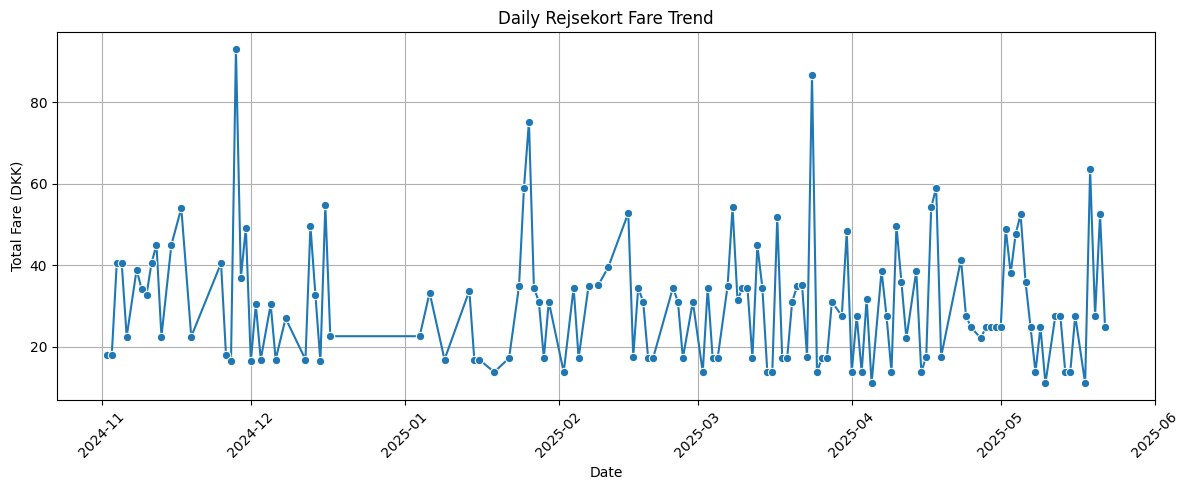

In [20]:
# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Step 1: Aggregate total daily fare
df_daily = df.groupby("Date")["Fare DKK"].sum().reset_index(name="TotalFare_DKK")

# Step 2: Plot the trendline
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_daily, x="Date", y="TotalFare_DKK", marker="o")
plt.title("Daily Rejsekort Fare Trend")
plt.ylabel("Total Fare (DKK)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [59]:

# Step 3: Forecast next 7 days with ARIMA (simple approach)
model = ARIMA(df_daily["TotalFare_DKK"], order=(1, 1, 1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=7)
forecast.index = pd.date_range(start=df_daily["Date"].iloc[-1] + pd.Timedelta(days=1), periods=7)


In [60]:
# Return the forecast for next 7 days
forecast_df = pd.DataFrame({
    "Date": forecast.index,
    "PredictedFare_DKK": forecast.values
})
forecast_df.reset_index(drop=True, inplace=True)
forecast_df

,Date,PredictedFare_DKK
0,2025-05-23,30.576032
1,2025-05-24,30.412878
2,2025-05-25,30.417519
3,2025-05-26,30.417387
4,2025-05-27,30.417390
5,2025-05-28,30.417390
6,2025-05-29,30.417390


In [63]:
df_region_daily = df.groupby(["Date", "Region"])["Fare DKK"].sum().reset_index()

# forecast for Midtjylland only - personal use
midt_daily = df_region_daily[df_region_daily["Region"] == "Midtjylland"]


# Step 3: Forecast next 7 days with ARIMA (simple approach)
model_jutland = ARIMA(midt_daily["Fare DKK"], order=(1, 1, 1))
model_fit_jutland = model_jutland.fit()

forecast_jutland = model_fit_jutland.forecast(steps=7)
forecast_jutland.index = pd.date_range(start=midt_daily["Date"].iloc[-1] + pd.Timedelta(days=1), periods=7)

In [64]:
forecast_df_jutland = pd.DataFrame({
    "Date": forecast_jutland.index,
    "PredictedFare_DKK": forecast_jutland.values
})
forecast_df_jutland.reset_index(drop=True, inplace=True)
forecast_df_jutland

,Date,PredictedFare_DKK
0,2025-05-23,26.469646
1,2025-05-24,26.243881
2,2025-05-25,26.275158
3,2025-05-26,26.270825
4,2025-05-27,26.271425
5,2025-05-28,26.271342
6,2025-05-29,26.271354


In [62]:
daily_total = df.groupby("Date")["Fare DKK"].sum().rename("TotalFare_DKK")
daily_sjaelland = df[df["Region"] == "Sjælland"].groupby("Date")["Fare DKK"].sum().rename("SjaellandFare_DKK")
df["Midt_2hr_Eligible"] = df["Midt_2hr_Eligible"].fillna(False)
daily_midt_eligible = df[df["Midt_2hr_Eligible"]].groupby("Date")["Fare DKK"].sum().rename("Midt_Eligible_Fare")


df_daily = pd.concat([daily_total, daily_sjaelland, daily_midt_eligible], axis=1).fillna(0).reset_index()



# Region-specific recommendation logic
def recommend(row):
    if row["SjaellandFare_DKK"] >= 60:
        return "DOT 12-hour pass"
    elif row["Midt_Eligible_Fare"] >= 26:
        return "Midttrafik 2-hour ticket"
    elif row["TotalFare_DKK"] >= 30:
        return "Consider Pendlerkort"
    else:
        return "Normal fare OK"

df_daily["Strategy_Recommendation"] = df_daily.apply(recommend, axis=1)



In [48]:

df_daily = df_daily.reset_index()
df_daily[df_daily["Strategy_Recommendation"] == "Midttrafik 2-hour ticket"]

,index,Date,TotalFare_DKK,SjaellandFare_DKK,Midt_Eligible_Fare,Strategy_Recommendation
35,35,2025-01-14,33.76,0.0,33.76,Midttrafik 2-hour ticket
73,73,2025-03-13,44.85,0.0,27.60,Midttrafik 2-hour ticket
84,84,2025-03-24,86.60,17.6,34.50,Midttrafik 2-hour ticket
90,90,2025-03-31,48.30,0.0,34.50,Midttrafik 2-hour ticket
126,126,2025-05-13,27.60,0.0,27.60,Midttrafik 2-hour ticket
131,131,2025-05-19,63.48,0.0,27.60,Midttrafik 2-hour ticket


In [ ]:
#df_daily = df_daily.reset_index()  #Will fail if executed more than 2 times
df_daily[df_daily["Strategy_Recommendation"] == "DOT 12-hour pass"]

,level_0,index,Date,TotalFare_DKK,SjaellandFare_DKK,Midt_Eligible_Fare,Strategy_Recommendation
17,17,17,2024-11-28,93.0,93.0,0.0,DOT 12-hour pass
42,42,42,2025-01-26,75.2,75.2,0.0,DOT 12-hour pass


In [54]:

#df_daily = df_daily.reset_index()  #Will fail if executed more than 2 times
df_daily[df_daily["Strategy_Recommendation"] == "Normal fare OK"]

,level_0,index,Date,TotalFare_DKK,SjaellandFare_DKK,Midt_Eligible_Fare,Strategy_Recommendation
0,0,0,2024-11-02,18.00,0.0,0.0,Normal fare OK
1,1,1,2024-11-03,18.00,0.0,0.0,Normal fare OK
4,4,4,2024-11-06,22.50,0.0,0.0,Normal fare OK
10,10,10,2024-11-13,22.50,0.0,0.0,Normal fare OK
13,13,13,2024-11-19,22.50,0.0,0.0,Normal fare OK
...,...,...,...,...,...,...,...
128,128,128,2025-05-15,13.80,0.0,0.0,Normal fare OK
129,129,129,2025-05-16,27.60,0.0,0.0,Normal fare OK
130,130,130,2025-05-18,11.04,0.0,0.0,Normal fare OK
132,132,132,2025-05-20,27.60,0.0,0.0,Normal fare OK
